# Advanced Machine Learning Assignment 1

Using sample code for CNN model to solve the Sign Language Image classigication problem. The structure of network was assumed to be the same and Bayesian Optimisation was used to find the optimal number of filters in the convolutional layers and the optimal number of neurons in the fully connected layers.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### ** Importing libraries **

In [ ]:
# standart data tools
import numpy as np
import pandas as pd

# common visualizing tools
import matplotlib.pyplot as plt
import seaborn as sns

# CNN layers and the Deep Learning model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam

# splitting tool for the validation set
from sklearn.model_selection import train_test_split

# to block unnecesarry warnings for updates etc.
import warnings
warnings.filterwarnings("ignore")

### **Loading the NumPy datasets**

In [ ]:
X = np.load("/content/drive/MyDrive/Datasets/Sign-language-digits-dataset/X.npy")
Y = np.load("/content/drive/MyDrive/Datasets/Sign-language-digits-dataset/Y.npy")

### Splitting train and test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
x_train = x_train.reshape(-1,64,64,1)
x_test = x_test.reshape(-1,64,64,1)

## Bayesian Optimisation



### **Bayesian Optimization Module by Thomas Huijskens**

**Source**: https://github.com/thuijskens/bayesian-optimization

In [ ]:
""" gp.py

Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)
        

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp


In [ ]:
def checkvals(params):

  l1 = params[0]
  l2 = params[1]
  l3 = params[2]
  l4 = params[3]
  l5 = params[4]
  l6 = params[5]
  l7 = params[6]
  d1 = params[7]
  d2 = params[8]
  d3 = params[9]


  CNN_model = Sequential()

  CNN_model.add(Conv2D(filters=l1,kernel_size=(5,5),activation="relu",padding="same",input_shape=(64,64,1)))
  CNN_model.add(Conv2D(filters=l2,kernel_size=(5,5),activation="relu",padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

  CNN_model.add(Conv2D(filters=l3,kernel_size=(4,4),activation="relu",padding="same"))
  CNN_model.add(Conv2D(filters=l4,kernel_size=(4,4),activation="relu",padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

  CNN_model.add(Dropout(0.2))

  CNN_model.add(Conv2D(filters=l5,kernel_size=(3,3),activation="relu",padding="same"))
  CNN_model.add(Conv2D(filters=l6,kernel_size=(3,3),activation="relu",padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

  CNN_model.add(Dropout(0.2))

  CNN_model.add(Conv2D(filters=l7,kernel_size=(2,2),activation="relu",padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2,2),padding="same"))

  CNN_model.add(Dropout(0.2))

  CNN_model.add(Flatten())

  CNN_model.add(Dense(d1,activation="relu"))
  CNN_model.add(Dense(d2,activation="relu"))
  CNN_model.add(Dense(d3,activation="relu"))

  CNN_model.add(Dense(10,activation="softmax"))

  CNN_model.compile(optimizer=Adam(lr=0.0002),loss=keras.losses.categorical_crossentropy,metrics=["accuracy"])
  results = CNN_model.fit(x_train,y_train,epochs=60,verbose = 0, validation_data=(x_test,y_test))
  print("Done.")
  return results.history

In [ ]:
def sample_loss(params):
  return (checkvals(params))["val_accuracy"][-1]

In [ ]:
#bounds = np.array([[2, 16], [16, 32], [16, 32], [16, 32], [16, 32], [48, 64], [16, 32], [112, 144], [56, 72], [32, 48]])
#bounds = np.array([[15, 17], [31, 33], [31, 33], [31, 33], [31, 33], [63, 65], [31, 33], [127, 129], [63, 65], [39, 41]])
bounds = np.array([[2, 128], [2, 128], [2, 128], [2, 128], [2, 128], [2, 128], [2, 128], [2, 128], [2, 128], [2, 128]])

print(bounds)

xp, yp = bayesian_optimisation(n_iters=40, sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=15)

[[  2 128]
 [  2 128]
 [  2 128]
 [  2 128]
 [  2 128]
 [  2 128]
 [  2 128]
 [  2 128]
 [  2 128]
 [  2 128]]
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


In [ ]:
#print(xp)
#print(yp)

# The maximum is at:
xp_hat = np.round(xp[np.array(yp).argmax(), :])
opt_vals = np.round(xp_hat)
print(opt_vals)

[ 54.  54. 114. 125.  43.  74.  45.  95.  50.  87.]


In [ ]:
results = checkvals(opt_vals)

Done.


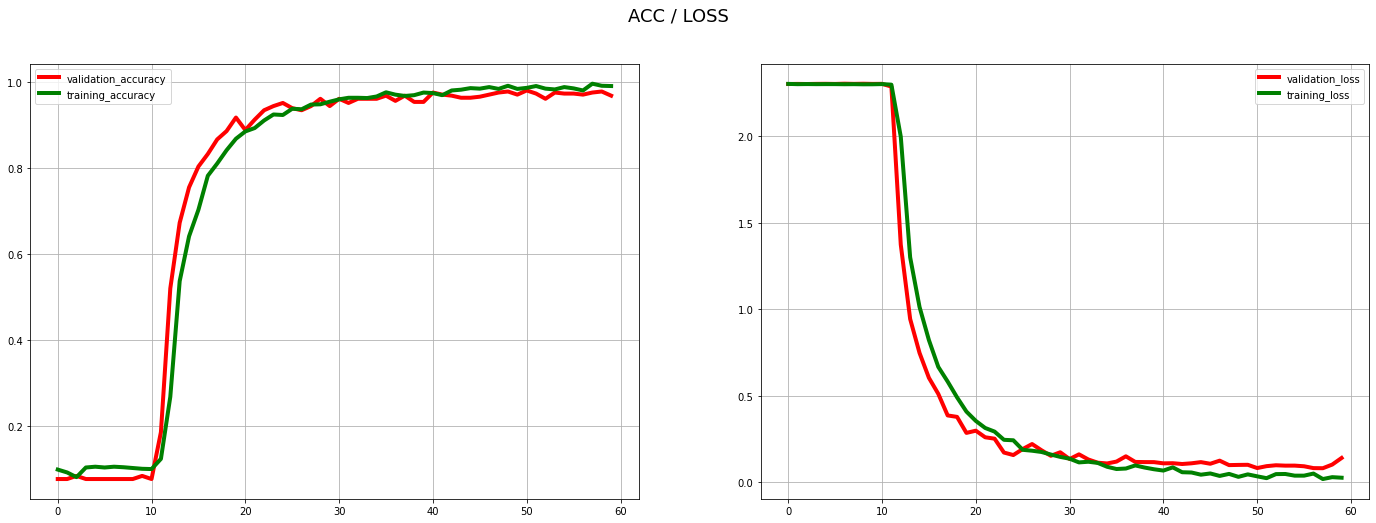

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(results["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(results["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(results["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

In [ ]:
print(results["accuracy"][-1])
print(results["val_accuracy"][-1])

0.9909035563468933
0.9685230255126953
